# Beaver Tutorial 6: ECG Arrhythmia Classification (Data Owner)

Train an XGBoost model on the MIT-BIH dataset with privacy-preserving collaboration.

Run this alongside `06-ecg-ds.ipynb` in a separate tab.


## Step 1: Setup


In [1]:
!uv pip install pandas numpy scikit-learn xgboost matplotlib seaborn keras torch sdv pyarrow -q

In [2]:
# NOTE: Default Keras backend is PyTorch for notebook stability.
# If you switch to TensorFlow, import it before beaver on Apple Silicon to avoid a pyarrow/tf.data hang.
# References:
# - https://github.com/google/array_record/issues/179
# - https://github.com/tensorflow/tensorflow/issues/98563
# - https://github.com/huggingface/datasets/issues/7419
import os

os.environ.setdefault("KERAS_BACKEND", "torch")

import beaver
from beaver import Twin

# Initialize Beaver session
bv = beaver.ctx()
session = bv.active_session()
session.reset(force=True)

print(f"You: {bv.user}")
print(f"Peer: {session.peer}")


🔄 Auto-load replies enabled for client1@sandbox.local (polling every 0.5s)
🟢 Active session loaded: dev_session_1767853045
   Peer: client2@sandbox.local
  Deleted: data/ (0 files)
✓ Session reset: 0 files deleted
You: client1@sandbox.local
Peer: client2@sandbox.local


In [3]:
# session.open()

## Step 2: Load MIT-BIH Data


In [4]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

In [5]:
import sdv
from sdv.metadata import Metadata
from sdv.single_table import GaussianCopulaSynthesizer

In [6]:
from beaver import sample_data

# Download ECG data
ds = sample_data.ecg_arrhythmia
real_path = ds.real.download()

✓ Already downloaded: /Users/madhavajay/.biovault/cache/beaver/sample-data/ecg_arrhythmia/MIT-BIH Arrhythmia Database.csv


In [7]:
label_col = "type"

def build_mock_from_real(real_df, seed=42, sample_size=500, max_feature_cols=20):
    """Build synthetic mock data using SDV GaussianCopula."""
    # Sample if too large
    if len(real_df) > sample_size:
        real_df = real_df.sample(sample_size, random_state=seed).reset_index(drop=True)

    # Select feature columns (exclude record and label)
    feature_cols = [c for c in real_df.columns if c not in ("record", label_col)]
    if max_feature_cols is not None:
        feature_cols = feature_cols[:max_feature_cols]

    # Build smaller dataframe for synthesis
    cols = ["record", label_col] + feature_cols
    cols = [c for c in cols if c in real_df.columns]  # only existing cols
    df_small = real_df[cols].copy()

    # Setup SDV metadata
    metadata = Metadata.detect_from_dataframe(data=df_small, table_name="ecg")
    metadata.update_column(table_name="ecg", column_name=label_col, sdtype="categorical")
    if "record" in df_small.columns:
        metadata.update_column(table_name="ecg", column_name="record", sdtype="categorical")

    # Fit and generate synthetic data
    synthesizer = GaussianCopulaSynthesizer(metadata)
    synthesizer.fit(df_small)
    mock_df = synthesizer.sample(len(df_small))

    return real_df[cols].reset_index(drop=True), mock_df, feature_cols

In [8]:
raw_df = pd.read_csv(real_path).dropna()
raw_df

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,101,N,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,...,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,101,N,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,...,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,101,N,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,...,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,101,N,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,...,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,101,N,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,...,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100684,234,N,240,241.0,-0.110230,1.420339,1.403346,1.403346,-0.115682,14,...,-0.069234,5,6,20,9,-0.069234,-0.068378,-0.065373,-0.060779,-0.054383
100685,234,N,241,243.0,-0.119014,1.424782,1.420328,1.420328,-0.134406,13,...,-0.069530,7,5,20,8,-0.069530,-0.069290,-0.066317,-0.053437,-0.045120
100686,234,N,243,252.0,0.173524,-0.443214,1.436878,-0.714642,-0.136431,38,...,-0.089396,9,7,24,8,-0.089396,-0.088155,-0.078611,-0.066763,-0.058650
100687,234,N,252,244.0,-0.119820,-0.401522,1.337051,-0.688560,-0.125076,27,...,-0.065487,3,1,12,8,-0.065487,-0.065487,-0.064941,-0.064941,-0.061120


In [9]:
real_df, mock_df, feature_cols = build_mock_from_real(raw_df)

/Users/madhavajay/dev/biovault-beaver/workspace1/sandbox/client1@sandbox.local/.venv/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



## Step 3: Publish Twin


In [10]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(real_df['type'])
label_names = list(label_encoder.classes_)

# Features
X = real_df.drop(columns=['record', 'type']).astype('float32').to_numpy()
print(f"Samples: {len(X)}, Features: {X.shape[1]}")
print(f"Classes: {label_names}")

Samples: 500, Features: 20
Classes: ['F', 'N', 'Q', 'SVEB', 'VEB']


In [11]:
mock_y = label_encoder.fit_transform(mock_df['type'])

# Features
mock_X = mock_df.drop(columns=['record', 'type']).astype('float32').to_numpy()
print(f"Samples: {len(mock_X)}, Features: {mock_X.shape[1]}")
print(f"Classes: {label_names}")

Samples: 500, Features: 20
Classes: ['F', 'N', 'Q', 'SVEB', 'VEB']


In [12]:
ecg = Twin(
    public={"X": mock_X, "y": mock_y, "label_names": label_names},
    private={"X": X, "y": y, "label_names": label_names},
    name="ecg",
)

session.remote_vars["ecg"] = ecg
print("Published 'ecg' twin!")

🌍 Using PUBLIC data from Twin 'ecg...'
📢 Published Twin 'ecg' (public side available at: syft://client1@sandbox.local/shared/biovault/sessions/dev_session_1767853045/data/44ebe7a932fe47009667b0b617a76731.beaver)
Published 'ecg' twin!


In [13]:
ecg

⚠️  Twin: ecg (REAL + MOCK DATA)
  ⚠️  Be careful: This Twin contains both real and mock data
  🔒 Private    {'X': array([[ 3.17000000e+02,  3.09000000e+02, -1.177255...    ← .value uses this
  🌍 Public    {'X': array([[ 2.4500000e+02,  2.4400000e+02, -7.5809129e...    ✓
  Live: ⚫ Disabled
  IDs: twin=47f2432a... private=afedcdb6... public=e614be87...

## Step 4: Wait for Training Request

**Run DS notebook Steps 1-4 now!**


## Step 5: Run Mock Training


In [14]:
request = bv.wait_for_request(ecg, timeout=600)
request


⏳ Waiting for request on 'ecg'...
📬 Request received: request_train_xgboost_for_result_request
   From: client2@sandbox.local


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: train_xgboost_result
   Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: train_xgboost

⚙️  Static Parameters:
  • arg[0]: dict = {'_beaver_twin_ref': True, 'twin_id': '47f2432a...

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=a91e90e4c07d... result=989fe135d9cb...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🧪 Testing on mock/public data...
🔍 [post-execution] Figures to capture: 2
🔍 [post-execution] Already captured IDs: {5499994528, 5500456304}
🔍 [post-execution] Fig: id=5499994528, already_captured=True
  ⏭️  Skipping (already captured)
🔍 [post-execution] Fig: id=5500456304, already_captured=True
  ⏭️  Skipping (already captured)
Mock accuracy: 90.00%
📊 Public figures (2):


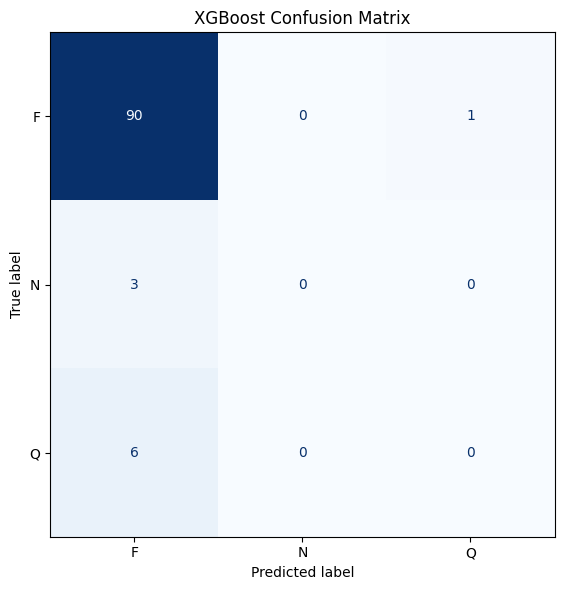

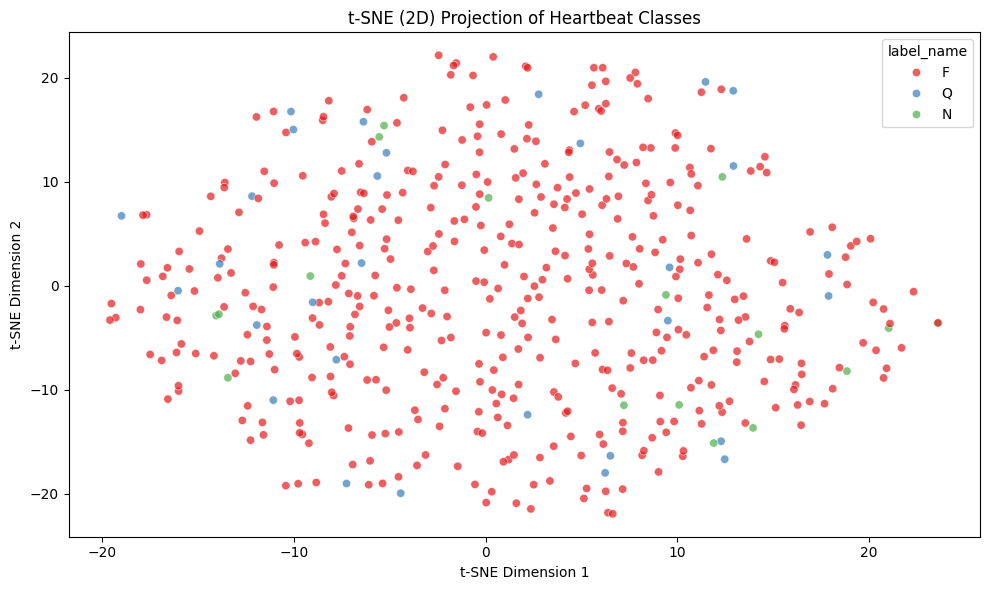

In [15]:
mock_result = request.run_mock()
acc = mock_result.data.public.get('test_accuracy')
if acc is None:
    print('Mock accuracy: N/A')
else:
    print(f"Mock accuracy: {acc:.2f}%")
mock_result.data.show_figures("public")

## Step 6: Run Real Training


⚙️  Executed: train_xgboost_result = train_xgboost(...)
   From: client2@sandbox.local
   Context: client1@sandbox.local
   Captured 2 figure(s)
✓ Execution complete
Real accuracy: 96.00%
📊 Private figures (2):


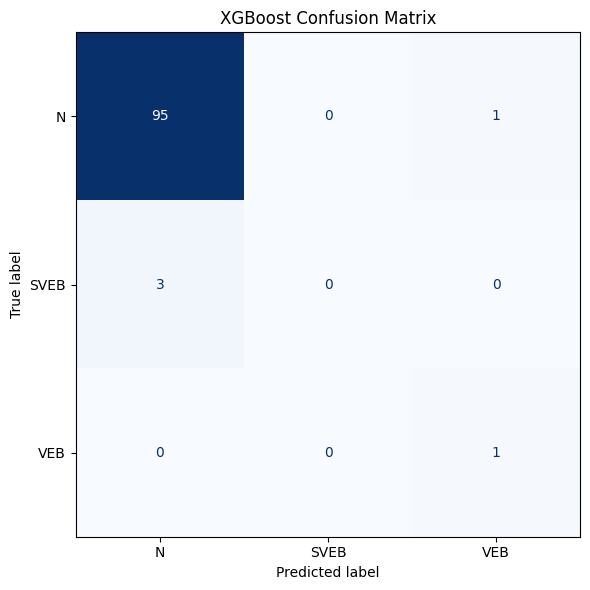

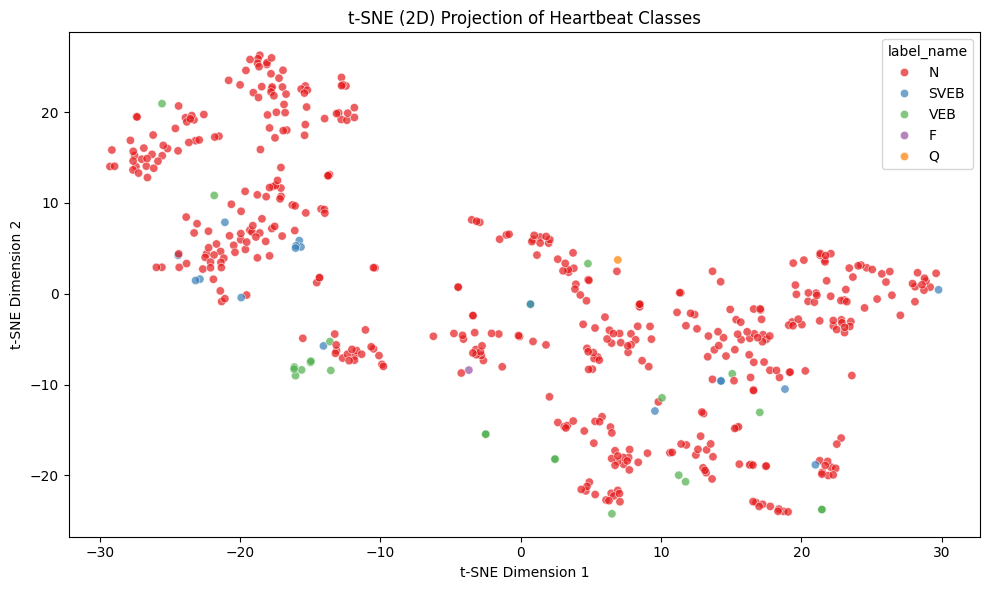

Model bytes: 988808


In [16]:
result = request.run()
if result.data is None or result.data.private is None:
    print('Real accuracy: N/A')
    print('No private results available (remote error).')
else:
    acc = result.data.private.get('test_accuracy')
    if acc is None:
        print('Real accuracy: N/A')
    else:
        print(f"Real accuracy: {acc:.2f}%")
    result.data.show_figures("private")
    print(f"Model bytes: {len(result.data.private.get('model_weights', b''))}")


## Step 7: Approve Results


In [17]:
result.approve()
print("Results approved and sent!")

✅ Approving result for: train_xgboost_result (twin_id=989fe135d9cb..., comp_id=a91e90e4c07d..., result_id=989fe135d9cb)
   Sending to: client2@sandbox.local
🔒 Using PRIVATE data from Twin 'train_xgboost_result...'
✓ Result sent to session data folder: /Users/madhavajay/dev/biovault-beaver/workspace1/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/dev_session_1767853045/data
💡 They can load it with: bv.inbox()['train_xgboost_result'].load()
Results approved and sent!


## Step 8: Wait for Keras Training Request


In [18]:
keras_request = bv.wait_for_request(ecg, timeout=600)
keras_request

⏳ Waiting for request on 'ecg'...
📬 Request received: request_train_keras_for_keras_request
   From: client2@sandbox.local


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: train_keras_result
   Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: train_keras

⚙️  Static Parameters:
  • arg[0]: dict = {'_beaver_twin_ref': True, 'twin_id': '47f2432a...

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=63e14348d340... result=47d4e5def9bd...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Step 9: Run Keras Mock Training


🧪 Testing on mock/public data...
🔍 [post-execution] Figures to capture: 1
🔍 [post-execution] Already captured IDs: {13717207376}
🔍 [post-execution] Fig: id=13717207376, already_captured=True
  ⏭️  Skipping (already captured)
Mock accuracy (Keras): 91.00%
📊 Public figures (1):


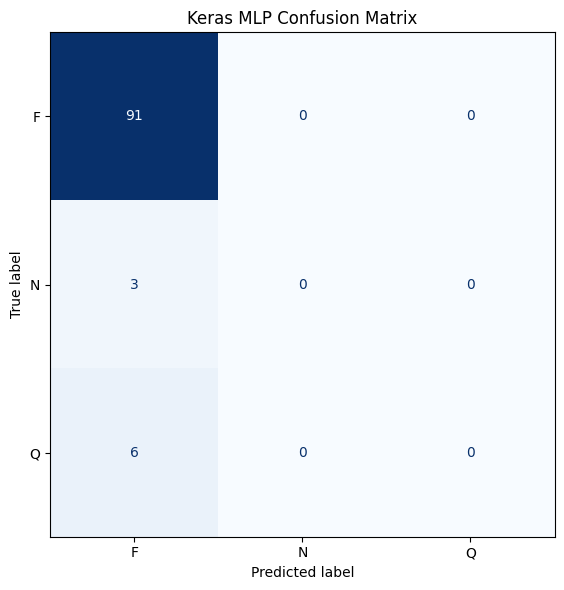

In [19]:
keras_mock = keras_request.run_mock()
acc = keras_mock.data.public.get('test_accuracy')
if acc is None:
    print('Mock accuracy (Keras): N/A')
else:
    print(f"Mock accuracy (Keras): {acc:.2f}%")
keras_mock.data.show_figures("public")

## Step 10: Run Keras Real Training


⚙️  Executed: train_keras_result = train_keras(...)
   From: client2@sandbox.local
   Context: client1@sandbox.local
   Captured 1 figure(s)
✓ Execution complete
Real accuracy (Keras): 96.00%
📊 Private figures (1):


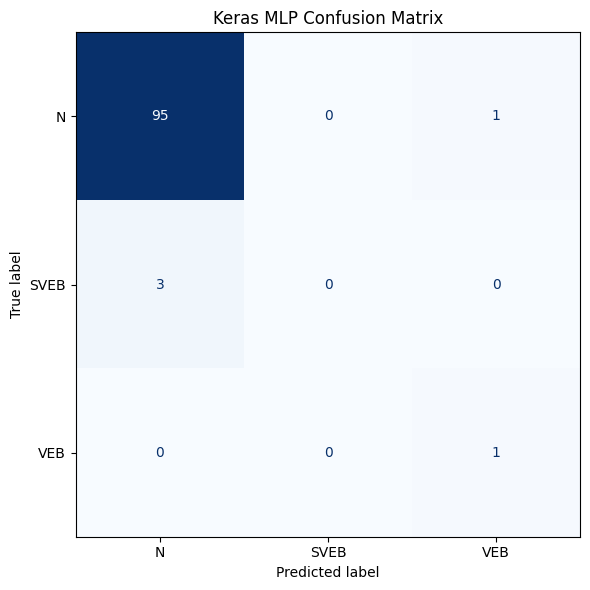

Model bytes: 43017


In [20]:
keras_result = keras_request.run()
if keras_result.data is None or keras_result.data.private is None:
    print('Real accuracy (Keras): N/A')
    print('No private results available (remote error).')
else:
    acc = keras_result.data.private.get('test_accuracy')
    if acc is None:
        print('Real accuracy (Keras): N/A')
    else:
        print(f"Real accuracy (Keras): {acc:.2f}%")
    keras_result.data.show_figures("private")
    print(f"Model bytes: {len(keras_result.data.private.get('model_weights', b''))}")


## Step 11: Approve Keras Results


In [21]:
keras_result.approve()
print("Keras results approved and sent!")

✅ Approving result for: train_keras_result (twin_id=47d4e5def9bd..., comp_id=63e14348d340..., result_id=47d4e5def9bd)
   Sending to: client2@sandbox.local
🔒 Using PRIVATE data from Twin 'train_keras_result...'
✓ Result sent to session data folder: /Users/madhavajay/dev/biovault-beaver/workspace1/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/dev_session_1767853045/data
💡 They can load it with: bv.inbox()['train_keras_result'].load()
Keras results approved and sent!


## Summary

- Loaded MIT-BIH ECG data and published a public/private twin
- Reviewed mock training locally
- Ran XGBoost remotely on private data
- Approved model weights and plots (t-SNE + confusion matrix) for DS
- Ran Keras MLP remotely and approved weights + confusion matrix

